## Dynamic Time Warping for Sequence-to-Sequence mapping of vector data


**Dates:**  

31/10/2023:  v0.8.0 on win11   
10/01/2025:  v0.8.3


#### Notes

DTW and Sequence Matching refers to matching problems where a sequence is defined as a sequence of atoms
and where the sequence matching can be broken up as a sequence of atom matches.

As such it applies to word matching  (with characters as atoms), sentence matching (with words or characters as atoms)
and the matching of any sequeunce of continuous vectors.

DTW finds the alignment   
$ (X_{i(s)},Y_{j(s)} ) \text{  for } s=1 ... N $   
that minimizes:   
$ \sum_s  ||X_{i(s)}- Y_{j(s)}|| + TC(d_i,d_j) $      with: $ d_i = i(s)-i(s-1), d_j = j(s)-j(s-1) $

+ with $|| ... ||$ denoting a *local distance metric* that measures distance between sequence elements
+ subject to the constraint that $i$ and $j$ need to *progress* in time, i.e. $i(s+1) >= i(s)$
+ specific transition constraints and/or costs that are algorithm specific (they can both be additive and multiplicative)

In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

C:\Users\compi\AppData\Local\Temp\ipykernel_24896\906663423.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Example 1:  1D feature vectors
- first define two some sequences   
    The feature vectors are scalars (1D vectors) 
- run a standard DTW algorithm on it and print a trellis   
    The local distance metric applied is 'Euclidean Squared' and use the Levenshtein algorithm for aligning, i.e.
    we can move diagonal, horizontal or vertical (always in the direction of time), 

DTW distance: 0.573 


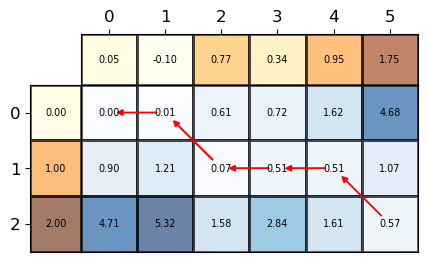

In [2]:
x1d = np.array([.05, -.1, 0.77, .335, .95, 1.75])
y1d = np.array([0.,1.,2.])
# we also define some plotting arguments for this example
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':5,'ftr_scale':.15,'fmt':"{:.2f}",'text_size':"xx-small"}
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='DTW',result='details')
print("DTW distance: %.3f " % dist)
dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)

## Steps in the DTW algorithm
1. Local Distance Computation
Compute for each pair (x_i, y_j) a distance.  This feature by feature distance, organized in a matrix is called the "local distance matrix"
2. Trellis Computation
In a trellis we compute accumulated distances.  Each cell contains a sum of local distances , starting up to the current cell.
Thus cell (Nx,Ny) contains the full sequence distance.   
Obviously the computation of cummulative distance this is subject to the allowed transitions.  
To maintain the memory of how we moved from one cell to another
we add backpointers in each cell
3. Backtracking
In order to find the alignment between the two sequences. We follow backpointers from the end back to the start

### Trellis Representation
The trellis is a matrix arrangement in which each cell (i,j) says something about the relationship between x\[i\] and y\[j\] or up to that moment in time for both sequences.   
We tend to add extra space in the plot for the feature vectors, typically clearly visable by the different colormaps.

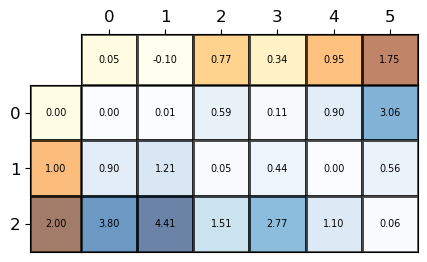

In [3]:
#STEP1: Compute the local distance matrix
fig1 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=ld_matrix,**plt_args)
fig1

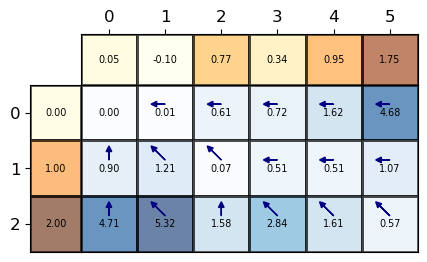

In [4]:
# STEP2: Compute the Cummulative Distance Matrix and add backpointers
fig2 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,**plt_args)
fig2

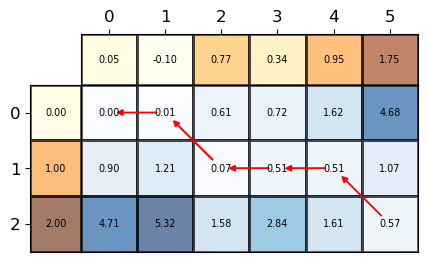

In [5]:
# STEP 3: Follow the backpointers in reverse order from end to beginning to find the optimal alignment
#xy_annot=True,ftr_annot=True,fig_width=4,fmt="{:.3f}",text_size="x-small"

fig3 = dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig3)

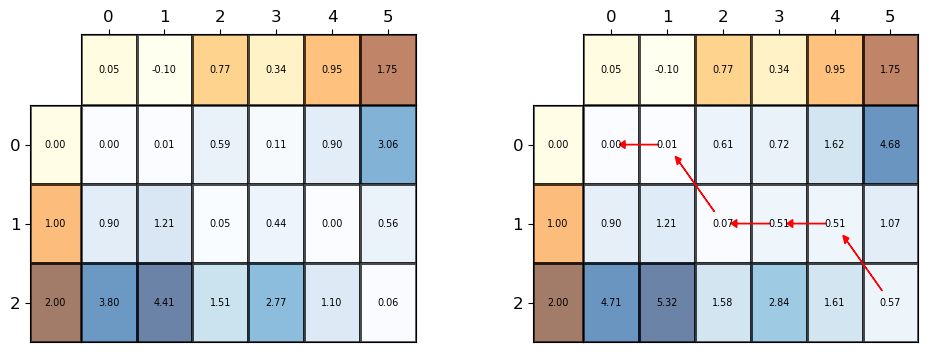

In [6]:
# we can also plot 2 side by side
fig = dtw.plot_trellis2(x1d,y1d,ld_matrix,cd_matrix,trace=trace,figsize=(10,4),**plt_args)
display(fig)

In [7]:
# compute "warped" versions of x,y on the basis of an alignment
# note: a warping obtained on 1 set of features can be applied to another set 
# given that the feature sequences are equally long for both processing types
x_wp,y_wp = dtw.warp(x1d,y1d,trace)
pd.DataFrame((x_wp,y_wp))

,0,1,2,3,4,5
0,0.05,-0.1,0.77,0.335,0.95,1.75
1,0.00,0.0,1.00,1.000,1.00,2.00


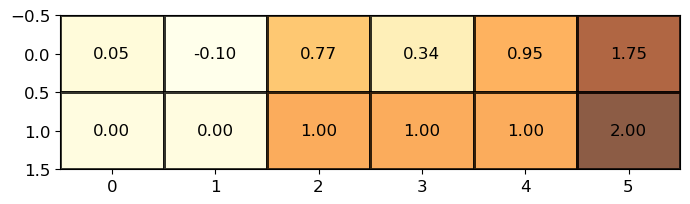

In [8]:
f,ax=plt.subplots(figsize=(8,2))
ax.invert_yaxis()
dtw.text_heatmap(np.array([x_wp,y_wp]),ax=ax,annot=True,edgecolor='k',cmap='YlOrBr',alpha=.75)

DTW distance: 3.360 


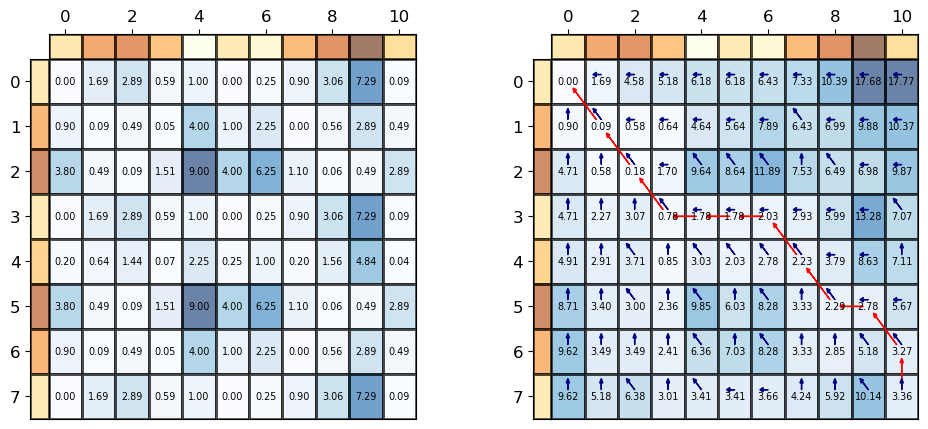

In [9]:
x1d = np.array([.05, 1.3, 1.7, 0.77, -1.,0.,-0.5, .95, 1.75,2.7,.3])
y1d = np.array([0.,1.,2.,0.,.5,2,1.,0.])
# we also define some plotting arguments for this example
plt_args = {'xy_annot':True,'ftr_annot':False,'fig_width':10,'ftr_scale':.05,'fmt':"{:.2f}",'text_size':"xx-small"}
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x1d,y1d,trans='DTW',result='details')
print("DTW distance: %.3f " % dist)

dtw.plot_trellis(x=x1d,y=y1d,xy_mat=cd_matrix,bptrs=bptrs,trace=trace,**plt_args)
dtw.plot_trellis2(x1d,y1d,ld_matrix,cd_matrix,bptrs=bptrs,trace=trace,**plt_args)

## Multi-dimensional Features
In this exampe we pass 2D feature vectors

In [10]:
#x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
x2d = np.array([[0.,1.,2.,1.,0.,0.1,.05],[0.3,1.3,1.5,1.5,1.,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2],[1.,1.,1.,1.,-1]]).T + .1*np.random.rand(5,2)
plt_args = {'fig_width':8,'xy_annot':True,'ftr_annot':True,            
            'xy_args':{'alpha':.2,'edgecolor':'k'}, 
            'bptr_args':{'color':'orange','linewidth':3},
            'ftr_args':{'cmap':'YlOrBr','edgecolor':'g','alpha':.3},
            }



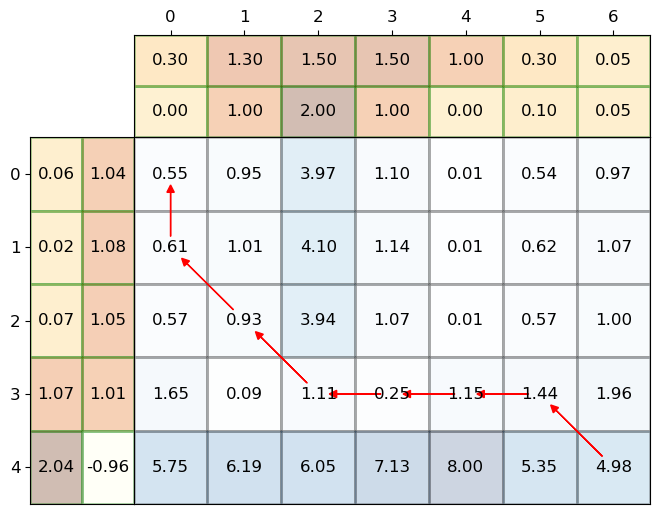

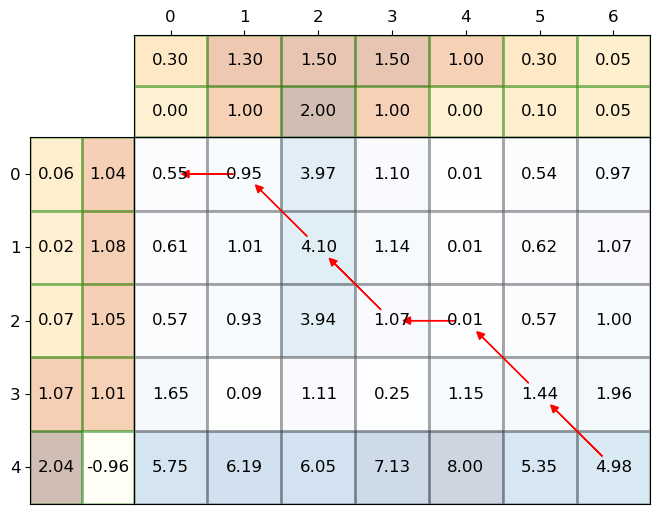

In [11]:
# By increasing the costs for off-diagonal transition, you force the alignment to become maximally diagonal
x_ftrs=x2d
y_ftrs=y2d
# case 1: small off-diagonal costs
trans = {'dx':[-1,-1,0], 'dy':[-1,0,-1], 'm':[1.0,1.2,1.2] }
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans=trans,result='details')
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
# case 2: large off-diagonal costs
trans = {'dx':[-1,-1,0], 'dy':[-1,0,-1], 'm':[1.0,2.,2.] }
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans=trans,result='details')
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)

## ITAKURA constraints
In sequence matching one may generally expect that the alignment path will follow the main diagonal closely. 
Long verticle or horizontal segments in the alignment are indications of a bad mismatch or significant insertion/deletions at those locations.

In the case of speech, things are no different as speaking rate differences tend to be limited.
Hence, popular in the speech community are the so called ITAKURA constraints in sequence matching.   
Itakura allows single jump in x or y direction while the other index just increases by 1 .  
In the dtw.dtw() implementation we penalize such jump moves by 20% vs. regular diagonal moves.   
This allows for a speedup of x2 on either axis.
At the same time it implies that certain cells in the trellis can never be reached.  
One of the bigger problems is that it is very hard to align variable length noise segments as for these a warping >> 2 may be acceptable.

In the dtw() module a few alternatives are available, that may be selected depending on the application:

- ITA: baseline symmetric DP with single jump allowed in x or y
- ITX: x-time synchronous DP
- ITY: y-time synchronous DP
- ITX3: x-time synchronous DP with Delta-y up to 3
- ITY3: y-time synchronous DP with Delta-x up to 3
- ITS: symmetric DP with infinite sized warping in both x and y possible
        (combintation of 'ITA' and 'DTW').  
        
Due to the warping constraints, certain areas in the trellis are not reachable and show infinite cost.  Exception is the ITS variant in which exery cell in the trellis is reachable 


C:\Users\compi\miniforge3\envs\py310t\lib\site-packages\matplotlib\colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


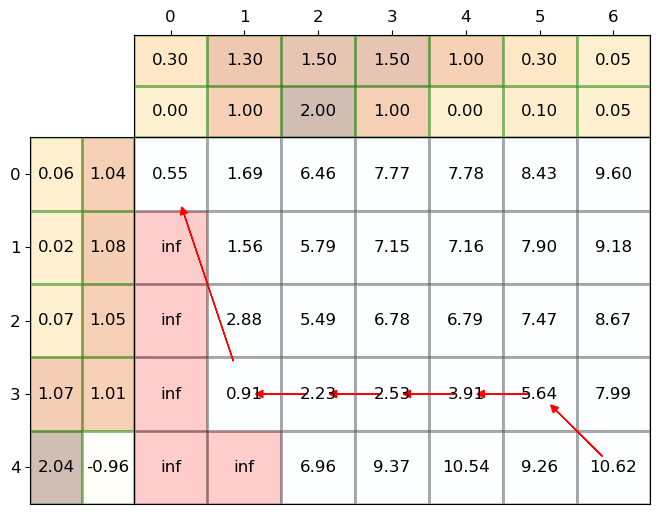

DTW distance =  10.621098428518856


In [12]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='ITX3',result='details',CLIP=False)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=cd_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

## Admissible Transitions and acceptable speedups
The ITAKURA constraints allow for a maximum x2 speedup in either direction.  
This makes sense during speech, but in silence periods much more may be required.  
Therefore it is advised to combine endpointing with the ITAKURA DTW implementation. 
If Nx > 2 times Ny, then the final cell in the trellis will not be reached.
The **IT2** constraints are a mix of ITAKURA and LEVENSHTEIN but with high costs on the horizontal / vertical moves.
It will resut in an alignment for ANY lengths Nx,Ny and in matching segments the ITAKURA constraints will dominate.

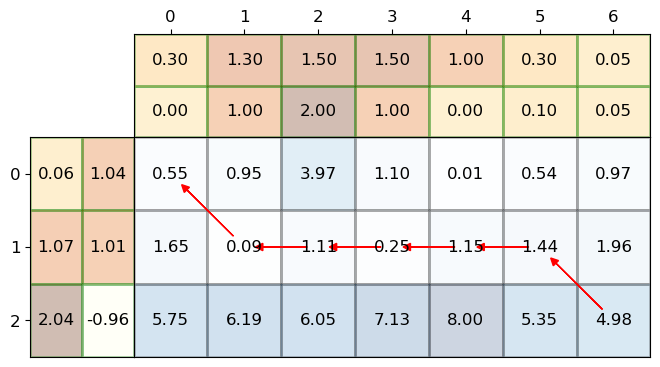

DTW distance =  9.560464344477193


In [13]:
x_ftrs=x2d
y_ftrs=y2d[(0,3,4),:]
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_ftrs,y_ftrs,trans='DTW',result='details',CLIP=False)
fig = dtw.plot_trellis(x=x_ftrs,y=y_ftrs,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)

# Now with speech data

In [14]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
# sa1: she had your dark suit in greasy washwater all year
# sa2: don't ask me to carry an oily rag like that
# note there are some word segmentation errors in sa1, phn segmentations are OK
yname = dir+'timit/audio/train/dr1/fcjf0/sa2'
xname = dir+'timit/audio/train/dr1/fdaw0/sa2'
#
#yname = dir+'digits/5752'
#xname = dir+'digits/2927'
xwavdata, sr = Spch.load(xname+".wav")
ywavdata, sr = Spch.load(yname+".wav")

xsegdata = Spch.read_seg_file(xname+ ".wrd",dt=1/sr,fmt='float32')
ysegdata = Spch.read_seg_file(yname+ ".wrd",dt=1/sr,fmt='float32')
# compute a spectrogram with default parameters

n_mels = None
shift=0.01
length=0.03
n_shift = int(shift*sr)
n_length = int(length*sr)
#
xspgdata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
xmeldata = Sps.spectrogram(xwavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,xnfr)=xspgdata.shape
d_freq = sr/(2.*(nparam-1))
yspgdata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,preemp=0.,n_mels=None)
ymeldata = Sps.spectrogram(ywavdata,sample_rate=sr,f_shift=shift,n_mels=24)

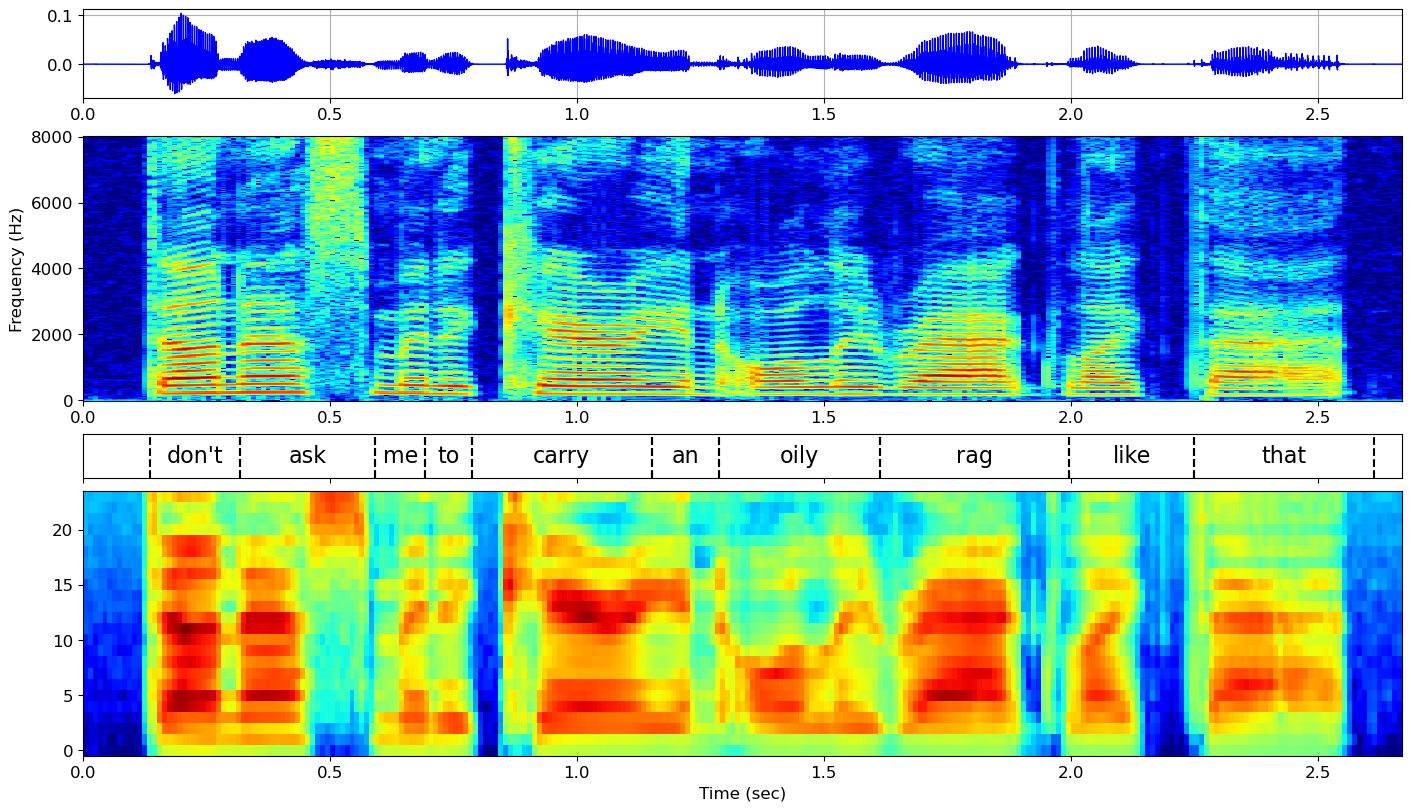

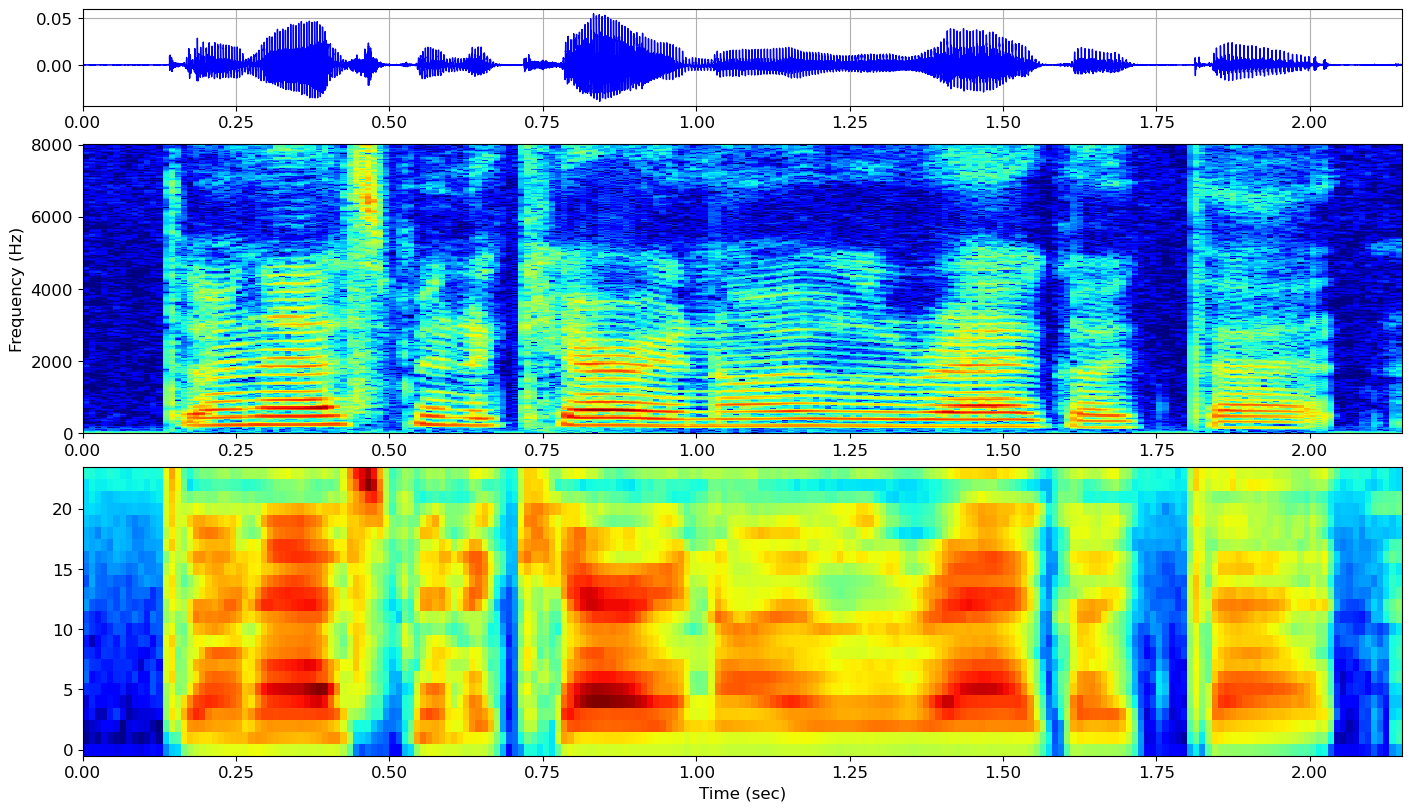

In [15]:
# just displaying the spectrograms and mel spectrograms of both sentences
fig = Spd.PlotSpgFtrs(wavdata=xwavdata,spgdata=xspgdata,segdata=[xsegdata],
                      img_ftrs=[xmeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
#
fig = Spd.PlotSpgFtrs(wavdata=ywavdata,spgdata=yspgdata, #segwav=ysegdata,
                  img_ftrs=[ymeldata],sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)

## DTW

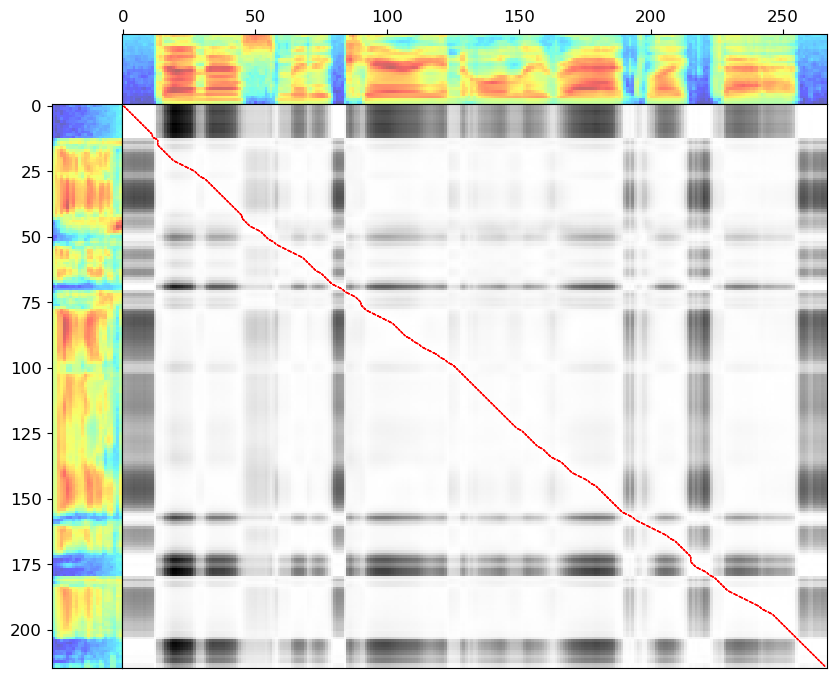

In [16]:
plt_args = {'fig_width':10,'ftr_scale':.1,'ftr_args':{'cmap':'jet','edgecolor':None},
            'xy_args':{'cmap':'Greys','alpha':1} }
x_ftrs = xmeldata.T
y_ftrs = ymeldata.T
#x_ftrs = xspgdata.T
#y_ftrs = yspgdata.T

cost,trace,ld_matrix,cd_matrix,_ = dtw.dtw(x_ftrs,y_ftrs,trans='ITY',result='details')
fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=y_ftrs,x=x_ftrs,**plt_args)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,x=x_ftrs,y=y_ftrs)
#fig = dtw.plot_trellis(xy_mat=ld_matrix,trace=trace,y=yspgdata[0:255,:].T,x=xspgdata[0:255,:].T,**plt_args)
fig

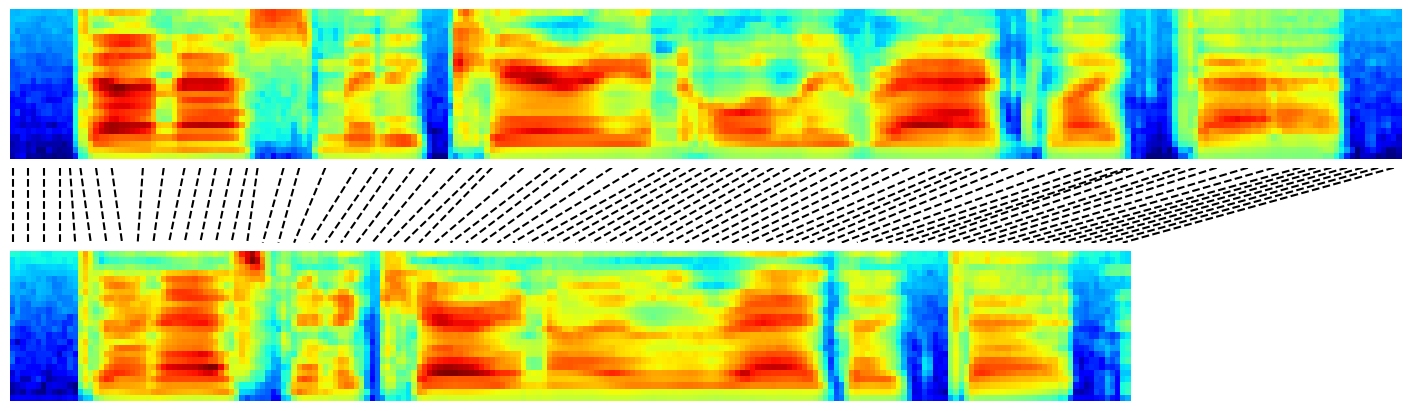

In [17]:
dtw.plot_align(x_ftrs,y_ftrs,trace,cmap='jet',down_sample=3,figsize=(14,4))

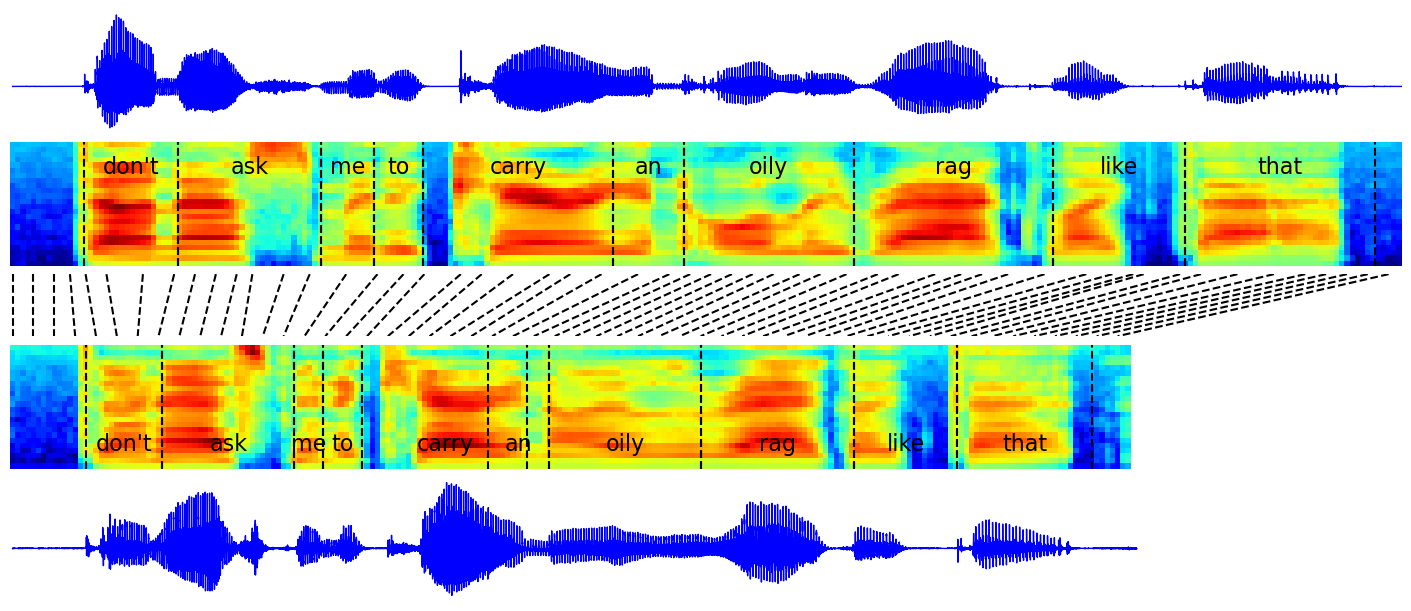

In [18]:
dtw.plot_align(x_ftrs,y_ftrs,trace,x_wav=xwavdata,y_wav=ywavdata,sr=sr,x_seg=xsegdata,y_seg=ysegdata,cmap='jet',segcolor='k',down_sample=4,figsize=(14,6))

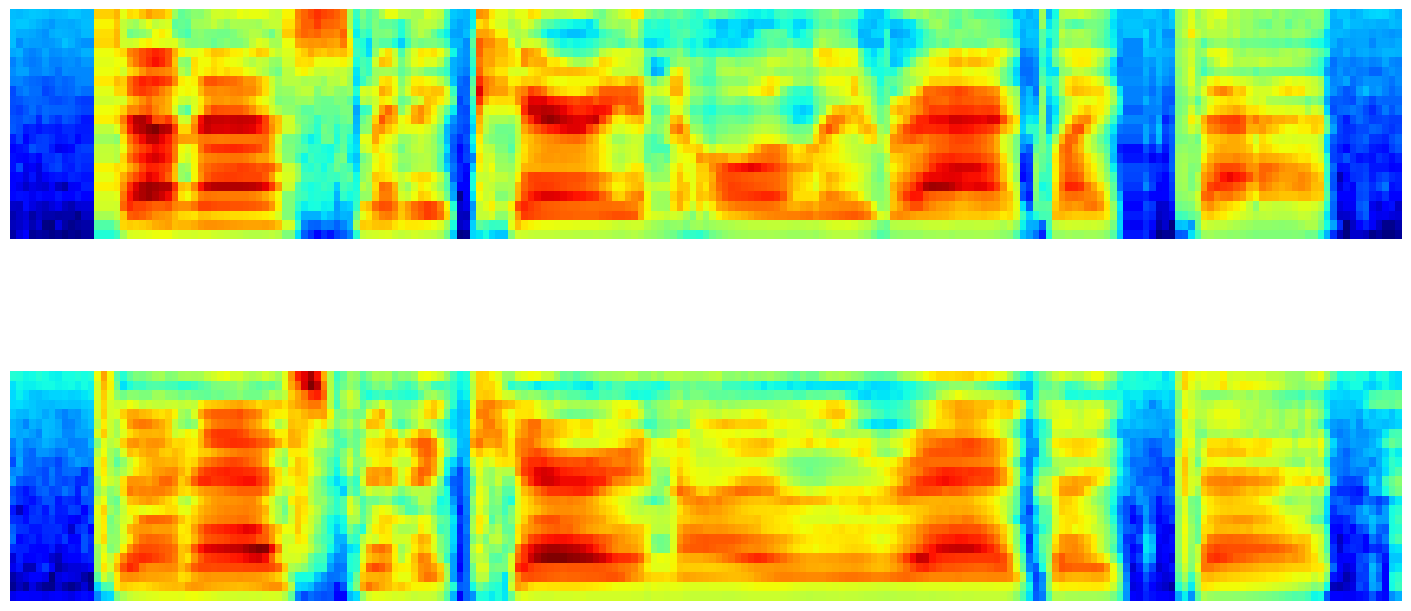

In [19]:
x_wp,y_wp = dtw.warp(x_ftrs,y_ftrs,trace)
dtw.plot_align(x_wp,y_wp,None,cmap='jet',down_sample=3,figsize=(14,6))

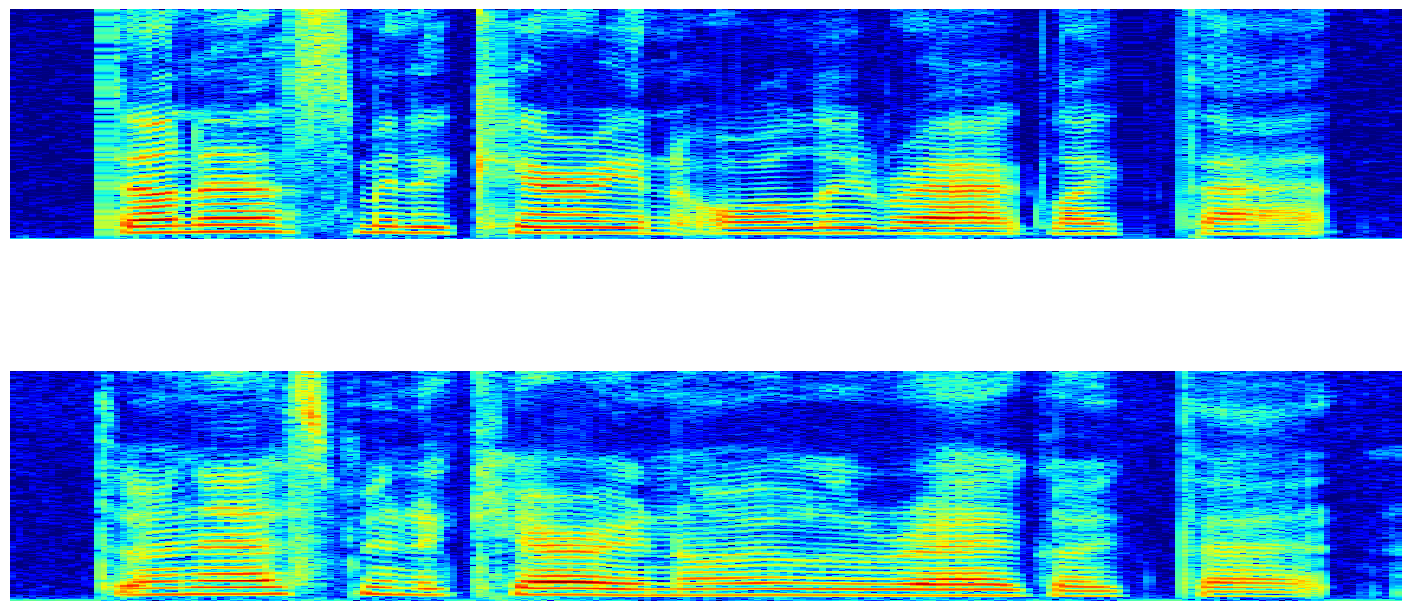

In [20]:
# Use the mel warping function to warp the spectrogram data
x_wpspg,y_wpspg = dtw.warp(xspgdata.T,yspgdata.T,trace)
dtw.plot_align(x_wpspg,y_wpspg,None,cmap='jet',down_sample=3,figsize=(14,6))

In [21]:
#
import librosa
def glim_synt(x,sample_rate=8000,shift=0.01):
    # dB to magnitude
    x_mag = librosa.db_to_power(x) **0.5
    hop_length = int(shift*sample_rate)
    xsyn = librosa.griffinlim(x_mag,hop_length=hop_length)
    return(xsyn)

Original spkr1


Warped spkr1


Original spkr2


Warped spkr2


Duo Speech


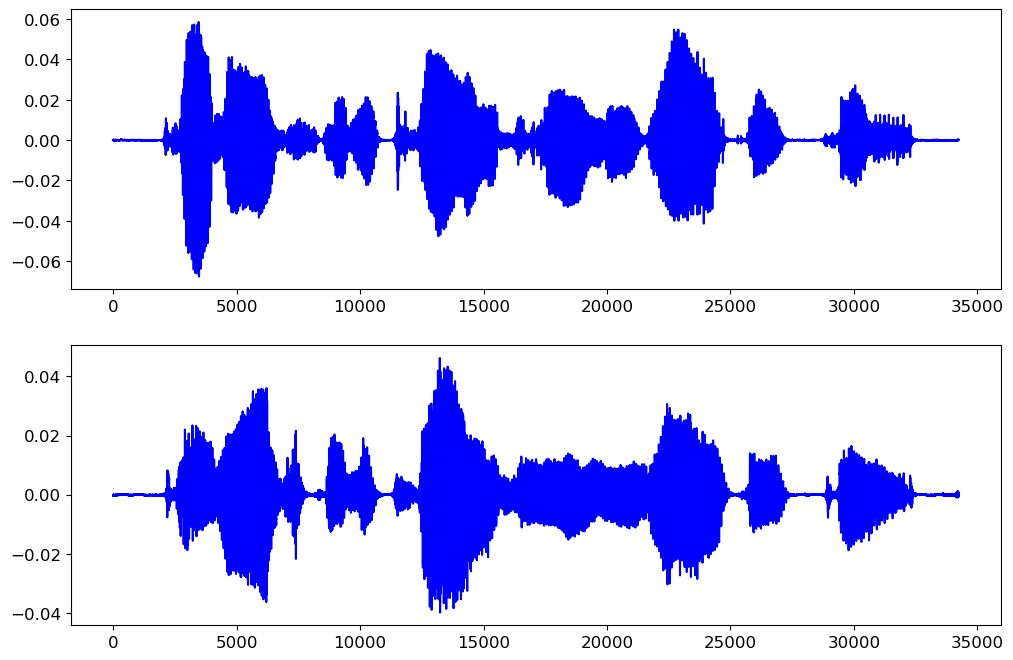

In [22]:
x_syn = Sps.synth_griffinlim(x_wpspg.T,sample_rate=sr)
y_syn = Sps.synth_griffinlim(y_wpspg.T,sample_rate=sr)
fig,ax = plt.subplots(2)
ax[0].plot(x_syn)
ax[1].plot(y_syn)
print("Original spkr1")
display(Audio(xwavdata,rate=sr))
print("Warped spkr1")
display(Audio(x_syn,rate=sr))
print("Original spkr2")
display(Audio(ywavdata,rate=sr))
print("Warped spkr2")
display(Audio(y_syn,rate=sr))
print("Duo Speech")
display(Audio(x_syn+y_syn,rate=sr))    

In [23]:
sr

16000